# Inference

In [3]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path

import dask

from hython.preprocess import apply_normalization
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.utils import missing_location_idx, reconstruct_from_missing, load, write_to_zarr, read_from_zarr
from hython.models.lstm import CustomLSTM

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_rmse, map_at_timesteps, ts_compare, plot_sampler, compute_kge_parallel


# Settings

In [44]:
WFLOW_MODEL =  "datademo"
SURROGATE_MODEL = "demo"
SEED = 1696

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc","actevap"] 

# DL model hyper parameters
HIDDEN_SIZE = 24
INPUT_SIZE = len(dynamic_names)
OUTPUT_SIZE = len(target_names)
NUMBER_STATIC_PREDICTORS = len(static_names)
TARGET_WEIGHTS = {t:0.5 for t in target_names}

# train/val parameters

train_start = "2016-01-01"
train_end = "2018-12-31"

test_start = "2019-01-01"
test_end = "2020-12-31"

train_range = slice(train_start,train_end)
test_range = slice(test_start, test_end)

EPOCHS = 60
SPATIAL_BATCH_SIZE = 256
TEMPORAL_SAMPLING_SIZE = 150 
SEQ_LENGTH = 360 

# sampler parameters

INTERVALS = [2, 2] # km
TRAIN_ORIGIN = [0, 0]
VAL_ORIGIN = [1, 1]

# missing policy
remove_lakes = False

assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])

# paths
wd =  Path("../data/datademo")
surrogate_data = wd / f"{WFLOW_MODEL}.zarr"
fp_surrogate_model = wd / f"{SURROGATE_MODEL}_v{TARGET_INITIALS}_h{HIDDEN_SIZE}_s{SEED}.pt"

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
Xd = read_from_zarr(url=surrogate_data , group="xd", multi_index="gridcell").sel(time = train_range).xd
Xs = read_from_zarr(url=surrogate_data , group="xs", multi_index="gridcell").xs
Y = read_from_zarr(url=surrogate_data , group="y", multi_index="gridcell").sel(time = train_range).y

Xd_test = read_from_zarr(url=surrogate_data, group="xd", multi_index="gridcell").sel(time = test_range).xd
Y_test = read_from_zarr(url=surrogate_data, group="y", multi_index="gridcell").sel(time = test_range).y

mask_missing = read_from_zarr(url=surrogate_data, group="mask" ).mask
#mask_lake = read_from_zarr(url=surrogate_data, group="mask_lake" ).mask_lake

#wflow_lakes = Xs.sel(feat="wflow_lakeareas").unstack()
wflow_dem = Xs.sel(feat="wflow_dem").unstack()
#wflow_landuse = Xs.sel(feat="wflow_landuse").unstack()

# train 
Xd = Xd.sel(feat=dynamic_names)
Xs = Xs.sel(feat=static_names)
Y = Y.sel(feat=target_names)

# test 
Y_test = Y_test.sel(feat=target_names)
Xd_test = Xd_test.sel(feat=dynamic_names)

# Model hyper parameters

In [47]:
# Define the spatial samplers for both training and validation sets. Remeber the subsets should not overlap, so choose different origins.

# training set
spatial_train_sampler = RegularIntervalSampler(intervals = INTERVALS, origin = TRAIN_ORIGIN)

# validation set
spatial_val_sampler = RegularIntervalSampler(intervals = INTERVALS, origin = VAL_ORIGIN) 

# Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.
data2d  = wflow_dem

idx = missing_location_idx(Xs.values)

sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, mask_missing)
sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, mask_missing)

# some useful metadata
print(sampler_train_meta)


SamplerResult(
 - id_grid_2d: (44, 33) 
 - idx_sampled_1d: (374,) 
 - idx_sampled_1d_nomissing: (374,)) 
 - idx_missing_1d: (0,) 
 - sampled_grid_dims: (22, 17) 
 - xr_coords: Coordinates:
  * lat      (lat) float64 46.2 46.22 46.24 46.26 ... 46.53 46.55 46.57 46.59
  * lon      (lon) float64 11.2 11.22 11.24 11.26 ... 11.44 11.46 11.48 11.5
    feat     <U9 'wflow_dem'


In [48]:
# Normalizing

# statistics from training
_, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
_, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
_, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

# use statistics from training to normalize test set
Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
Xd_test = apply_normalization(Xd_test, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
Y_test = apply_normalization(Y_test, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()


In [49]:
d_m = d_m.compute()
d_std = d_std.compute()
s_m = s_m.compute()
s_std = s_std.compute()
y_m = y_m.compute()
Y_std = y_std.compute()

In [50]:
Xd_test = Xd_test.values
Y_test = Y_test.values
Xs = Xs.values

# Initialize Model

In [51]:
model = CustomLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUMBER_STATIC_PREDICTORS)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=9, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

In [52]:
model.load_state_dict(torch.load(fp_surrogate_model))

<All keys matched successfully>

# Inference 

In [53]:
targets = xr.open_dataset(wd  / "output.nc", chunks= {"time":200}).isel(lat=slice(None, None, -1))
targets

<xarray.Dataset>
Dimensions:  (lon: 33, lat: 44, time: 2191)
Coordinates:
  * lon      (lon) float64 11.2 11.21 11.22 11.23 ... 11.47 11.48 11.49 11.5
  * lat      (lat) float64 46.6 46.59 46.58 46.57 ... 46.23 46.22 46.21 46.2
  * time     (time) datetime64[ns] 2015-01-02 2015-01-03 ... 2020-12-31
Data variables:
    actevap  (time, lat, lon) float32 dask.array<chunksize=(200, 44, 33), meta=np.ndarray>
    q_river  (time, lat, lon) float32 dask.array<chunksize=(200, 44, 33), meta=np.ndarray>
    vwc      (time, lat, lon) float32 dask.array<chunksize=(200, 44, 33), meta=np.ndarray>

In [54]:
# predict over the whole spatial domain using the model trained over the subsample
yhat = predict(Xd_test, Xs, model, SPATIAL_BATCH_SIZE, device=device)
yhat.shape

lat, lon, time = len(wflow_dem.lat),len(wflow_dem.lon), Xd_test.shape[1]
lat*lon ,time

# to original scale
yhat = (yhat*y_std) + y_m

# SM
y_target_sm, y_pred_sm = prepare_for_plotting(y_target=Y_test[:,:,[0]], y_pred = yhat[:,:,[0]], shape = (lat, lon, time), coords = targets.sel(time=test_range).coords)
y_target_sm.shape

# to original scale
y_target_sm = (y_target_sm*y_std[0]) + y_m[0]

y_target_sm = y_target_sm.chunk({"lat":20, "lon":20, "time":-1})
y_pred_sm = y_pred_sm.chunk({"lat":20, "lon":20, "time":-1})

if remove_lakes:
    y_target_sm = y_target_sm.where(~mask_lakes[...,None])
    y_pred_sm = y_pred_sm.where(~mask_lakes[...,None])

# ET
y_target_et, y_pred_et = prepare_for_plotting(y_target=Y_test[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords  = targets.sel(time=test_range).coords)
y_target_et.shape

y_target_et = (y_target_et*y_std[1]) + y_m[1]

if remove_lakes:
    y_target_et = y_target_et.where(~mask_lakes[...,None])
    y_pred_et = y_pred_et.where(~mask_lakes[...,None])


if "runoff" in target_names:
    y_target_run, y_pred_run = prepare_for_plotting(y_target=Y_test[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords  = targets.sel(time=test_range).coords)
    y_target_run.shape
    
    y_target_run = (y_target_run*y_std[2]) + y_m[2]
    
    if remove_lakes:
        y_target_run = y_target_run.where(~mask_lakes[...,None])
        y_pred_run = y_pred_run.where(~mask_lakes[...,None])  

Xs_o = (Xs*s_std)  + s_m

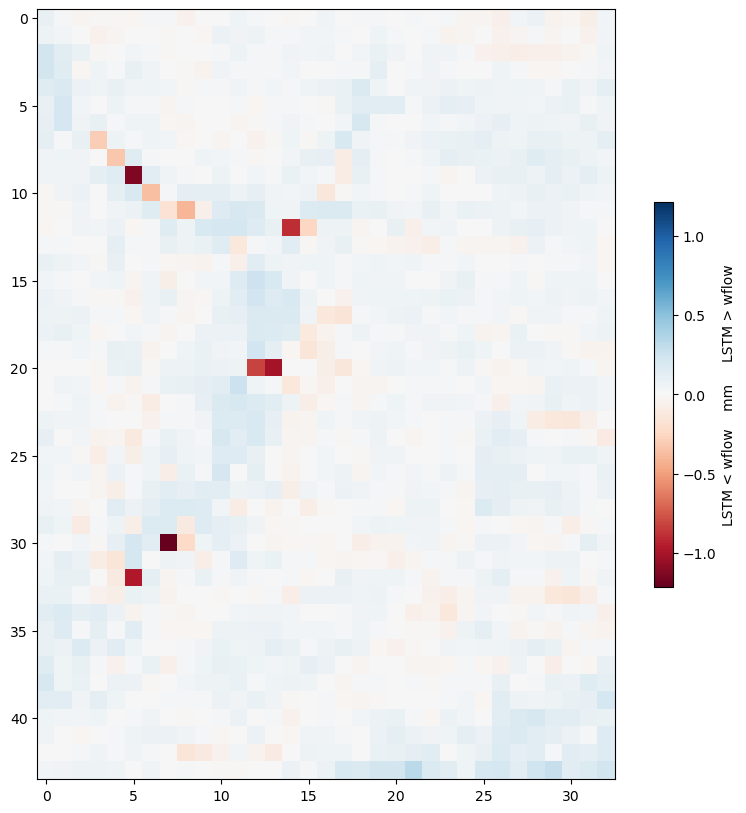

In [55]:
map_bias(y_target_sm, y_pred_sm)

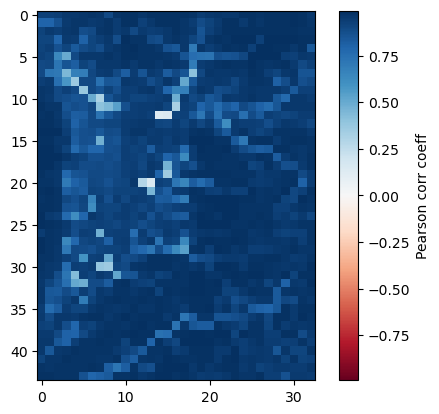

In [56]:
map_pearson(y_target_sm, y_pred_sm)